In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



2023-05-06 22:26:16.261019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# load and preprocess the data, define catergories, images are resized. 
# animal categories
categories = ['dog', 'panda', 'cat']
inputArray=[] #input array
outputArray=[] #output array
datadir='/Users/ejbeazleigh/Downloads/Animals/' 
#path which contains all the categories of images
for i in categories: 
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(32,55,3))
        inputArray.append(img_resized)
        outputArray.append(categories.index(i))
    print(f'loaded category:{i} successfully')

loading... category : dog
loaded category:dog successfully
loading... category : panda
loaded category:panda successfully
loading... category : cat
loaded category:cat successfully


In [4]:
#changing shape of data so that it doesnt corrupt the model, 
# printing shapes and integers to double check everythinf is okay and 
#model will not encounter issues
from tensorflow.keras.utils import to_categorical
x=np.array(inputArray, dtype="float")/255.0
y=np.array(outputArray)
print(x.shape)
print(y.shape)
print(x[0])
print(y[0])
y=to_categorical(y,3)
print(y[0])

(3000, 32, 55, 3)
(3000,)
[[[0.00196295 0.00173221 0.00123278]
  [0.00204008 0.00181341 0.00130437]
  [0.00209188 0.0018768  0.00134728]
  ...
  [0.00229087 0.00201031 0.00131412]
  [0.00226211 0.00197151 0.00130621]
  [0.00221604 0.00193571 0.00127183]]

 [[0.00197646 0.0017632  0.00145248]
  [0.00205421 0.00184084 0.00150051]
  [0.00214173 0.00195184 0.00160749]
  ...
  [0.00233112 0.00205281 0.00134987]
  [0.00231051 0.00202804 0.00133726]
  [0.00227616 0.00199043 0.00129365]]

 [[0.00164186 0.00142368 0.00115972]
  [0.00170171 0.00148465 0.00116886]
  [0.00174292 0.00154956 0.00123508]
  ...
  [0.00236031 0.00208347 0.00137612]
  [0.00234529 0.00206836 0.0013612 ]
  [0.00231826 0.00204094 0.00133217]]

 ...

 [[0.00162334 0.00128501 0.00091592]
  [0.00164586 0.00130775 0.00093839]
  [0.00171494 0.00137762 0.00100665]
  ...
  [0.0023652  0.0019961  0.00144252]
  [0.00229669 0.00192759 0.00137382]
  [0.00217746 0.00180782 0.00124993]]

 [[0.00159535 0.00125707 0.00088807]
  [0.001639

In [8]:
#defining the model
FCNNmodel = Sequential()

FCNNmodel.add(Flatten(input_shape=(32, 5, 3)))
FCNNmodel.add(Dense(512, activation='relu'))
FCNNmodel.add(Dense(256, activation='relu'))
FCNNmodel.add(Dense(128, activation='relu'))
FCNNmodel.add(Dropout(0.25))
FCNNmodel.add(Dense(3, activation='softmax'))

FCNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(FCNNmodel.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 480)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               246272    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 410,883
Trainable params: 410,883
Non-tr

In [9]:
print(FCNNmodel.input_shape)
print(FCNNmodel.output_shape)
print(y.shape)


(None, 32, 5, 3)
(None, 3)
(3000, 3)


In [17]:
# the Sequential object in Keras does not have a get_params() method, 
#which is required by scikit-learn's GridSearchCV to overcome this issue below i have 
#create an instance of KerasClassifier, a wrapper for Keras models that enables them to be used in scikit-learn,
#using this function.This will then enable me to get the optimal hyperparamaters for my CNN model
#which i then manually placed into my 'FCNNmodelBest'

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
# Define a function that creates your Keras model
def create_model(batch_size=16, epochs=10, optimizer='adam'):
    model = Sequential()
    model.add(Flatten(input_shape=(32,55, 3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create an instance of KerasClassifier with your create_model function
keras_model = KerasClassifier(build_fn=create_model)
# Define the parameters to search over
param_grid = {'batch_size': [16, 32, 64],'epochs': [10, 20, 30],'optimizer': ['adam', 'sgd']}
# Create the GridSearchCV object with keras_model as the estimator
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, scoring=['accuracy', 'f1'], refit='accuracy', cv=3)
# Fit the GridSearchCV object to your data
grid_result = grid.fit(x, y)
# Get the best parameters and the corresponding accuracy and f1 scores
best_params = grid_result.best_params_
print("Best parameters: ", best_params)


/var/folders/h7/pb5zg34j4_x_kt0pszyxqj980000gn/T/ipykernel_40648/44345226.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=create_model)


Epoch 1/10
125/125 [==============================] - 6s 38ms/step - loss: 0.6228 - accuracy: 0.6540
Epoch 2/10
125/125 [==============================] - 6s 47ms/step - loss: 0.4222 - accuracy: 0.8070
Epoch 3/10
125/125 [==============================] - 4s 36ms/step - loss: 0.4023 - accuracy: 0.8220
Epoch 4/10
125/125 [==============================] - 5s 41ms/step - loss: 0.3742 - accuracy: 0.8385
Epoch 5/10
125/125 [==============================] - 4s 33ms/step - loss: 0.3441 - accuracy: 0.8540
Epoch 6/10
125/125 [==============================] - 4s 33ms/step - loss: 0.3333 - accuracy: 0.8620
Epoch 7/10
125/125 [==============================] - 4s 33ms/step - loss: 0.3084 - accuracy: 0.8710
Epoch 8/10
125/125 [==============================] - 4s 33ms/step - loss: 0.2995 - accuracy: 0.8795
Epoch 9/10
125/125 [==============================] - 4s 33ms/step - loss: 0.3071 - accuracy: 0.8730
Epoch 10/10
32/32 [==============================] - 0s 6ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 5s 34ms/step - loss: 0.7401 - accuracy: 0.5065
Epoch 2/10
125/125 [==============================] - 4s 33ms/step - loss: 0.7027 - accuracy: 0.4925
Epoch 3/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6928 - accuracy: 0.5160
Epoch 4/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6969 - accuracy: 0.5170
Epoch 5/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6885 - accuracy: 0.5380
Epoch 6/10
125/125 [==============================] - 4s 34ms/step - loss: 0.6825 - accuracy: 0.5560
Epoch 7/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6858 - accuracy: 0.5480
Epoch 8/10
125/125 [==============================] - 4s 33ms/step - loss: 0.6783 - accuracy: 0.5710
Epoch 9/10
125/125 [==============================] - 4s 36ms/step - loss: 0.6763 - accuracy: 0.5785
Epoch 10/10
32/32 [==============================] - 0s 6ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 5s 33ms/step - loss: 0.6633 - accuracy: 0.5930
Epoch 2/10
125/125 [==============================] - 4s 33ms/step - loss: 0.4715 - accuracy: 0.7880
Epoch 3/10
125/125 [==============================] - 6s 46ms/step - loss: 0.4530 - accuracy: 0.7960
Epoch 4/10
125/125 [==============================] - 4s 34ms/step - loss: 0.4355 - accuracy: 0.7975
Epoch 5/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4230 - accuracy: 0.8085
Epoch 6/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4374 - accuracy: 0.8000
Epoch 7/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4056 - accuracy: 0.8160
Epoch 8/10
125/125 [==============================] - 4s 31ms/step - loss: 0.4029 - accuracy: 0.8115
Epoch 9/10
125/125 [==============================] - 4s 32ms/step - loss: 0.3835 - accuracy: 0.8250
Epoch 10/10
32/32 [==============================] - 0s 5ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 2s 11ms/step - loss: 0.9508 - accuracy: 0.5050
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 0.8050 - accuracy: 0.5010
Epoch 3/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7517 - accuracy: 0.4940
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7284 - accuracy: 0.4945
Epoch 5/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7179 - accuracy: 0.5020
Epoch 6/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7068 - accuracy: 0.5345
Epoch 7/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7077 - accuracy: 0.5135
Epoch 8/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7072 - accuracy: 0.5065
Epoch 9/10
125/125 [==============================] - 1s 11ms/step - loss: 0.7058 - accuracy: 0.4900
Epoch 10/10
32/32 [==============================] - 0s 4ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 2s 11ms/step - loss: 0.9432 - accuracy: 0.4975
Epoch 2/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7985 - accuracy: 0.4930
Epoch 3/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7488 - accuracy: 0.4965
Epoch 4/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7312 - accuracy: 0.4840
Epoch 5/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7192 - accuracy: 0.4955
Epoch 6/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7103 - accuracy: 0.5335
Epoch 7/10
125/125 [==============================] - 2s 12ms/step - loss: 0.7105 - accuracy: 0.4865
Epoch 8/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7063 - accuracy: 0.5085
Epoch 9/10
125/125 [==============================] - 2s 13ms/step - loss: 0.7058 - accuracy: 0.4975
Epoch 10/10
32/32 [==============================] - 0s 6ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
125/125 [==============================] - 2s 11ms/step - loss: 0.9427 - accuracy: 0.5125
Epoch 2/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7960 - accuracy: 0.5120
Epoch 3/10
125/125 [==============================] - 2s 12ms/step - loss: 0.7472 - accuracy: 0.4930
Epoch 4/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7257 - accuracy: 0.5065
Epoch 5/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7131 - accuracy: 0.5215
Epoch 6/10
125/125 [==============================] - 1s 12ms/step - loss: 0.7092 - accuracy: 0.5070
Epoch 7/10
125/125 [==============================] - 2s 12ms/step - loss: 0.7060 - accuracy: 0.5185
Epoch 8/10
125/125 [==============================] - 2s 12ms/step - loss: 0.7055 - accuracy: 0.5105
Epoch 9/10
125/125 [==============================] - 2s 12ms/step - loss: 0.7004 - accuracy: 0.5210
Epoch 10/10
32/32 [==============================] - 0s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 5s 32ms/step - loss: 0.6467 - accuracy: 0.6235
Epoch 2/20
125/125 [==============================] - 4s 33ms/step - loss: 0.4372 - accuracy: 0.8005
Epoch 3/20
125/125 [==============================] - 4s 32ms/step - loss: 0.4014 - accuracy: 0.8240
Epoch 4/20
125/125 [==============================] - 4s 33ms/step - loss: 0.3746 - accuracy: 0.8360
Epoch 5/20
125/125 [==============================] - 4s 34ms/step - loss: 0.3769 - accuracy: 0.8400
Epoch 6/20
125/125 [==============================] - 4s 35ms/step - loss: 0.3531 - accuracy: 0.8520
Epoch 7/20
125/125 [==============================] - 4s 34ms/step - loss: 0.3343 - accuracy: 0.8545
Epoch 8/20
125/125 [==============================] - 4s 32ms/step - loss: 0.3031 - accuracy: 0.8785
Epoch 9/20
125/125 [==============================] - 4s 32ms/step - loss: 0.3125 - accuracy: 0.8660
Epoch 10/20
125/125 [==============================] - 5s 39ms/step - loss: 0.3159 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 6s 39ms/step - loss: 0.7356 - accuracy: 0.5060
Epoch 2/20
125/125 [==============================] - 4s 35ms/step - loss: 0.7034 - accuracy: 0.5050
Epoch 3/20
125/125 [==============================] - 5s 37ms/step - loss: 0.6983 - accuracy: 0.5050
Epoch 4/20
125/125 [==============================] - 6s 47ms/step - loss: 0.6884 - accuracy: 0.5580
Epoch 5/20
125/125 [==============================] - 7s 57ms/step - loss: 0.6828 - accuracy: 0.5665
Epoch 6/20
125/125 [==============================] - 6s 46ms/step - loss: 0.6766 - accuracy: 0.5550
Epoch 7/20
125/125 [==============================] - 6s 49ms/step - loss: 0.6715 - accuracy: 0.5835
Epoch 8/20
125/125 [==============================] - 6s 47ms/step - loss: 0.6743 - accuracy: 0.5840
Epoch 9/20
125/125 [==============================] - 5s 41ms/step - loss: 0.6730 - accuracy: 0.5975
Epoch 10/20
125/125 [==============================] - 5s 43ms/step - loss: 0.6607 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 7s 40ms/step - loss: 0.6537 - accuracy: 0.6250
Epoch 2/20
125/125 [==============================] - 5s 39ms/step - loss: 0.4571 - accuracy: 0.7935
Epoch 3/20
125/125 [==============================] - 5s 41ms/step - loss: 0.4374 - accuracy: 0.7985
Epoch 4/20
125/125 [==============================] - 5s 42ms/step - loss: 0.4291 - accuracy: 0.8070
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.4280 - accuracy: 0.8110
Epoch 6/20
125/125 [==============================] - 5s 40ms/step - loss: 0.4043 - accuracy: 0.8230
Epoch 7/20
125/125 [==============================] - 5s 43ms/step - loss: 0.3997 - accuracy: 0.8180
Epoch 8/20
125/125 [==============================] - 5s 41ms/step - loss: 0.3876 - accuracy: 0.8270
Epoch 9/20
125/125 [==============================] - 5s 42ms/step - loss: 0.3893 - accuracy: 0.8285
Epoch 10/20
125/125 [==============================] - 5s 37ms/step - loss: 0.3670 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 3s 15ms/step - loss: 0.9401 - accuracy: 0.5020
Epoch 2/20
125/125 [==============================] - 2s 18ms/step - loss: 0.7941 - accuracy: 0.4950
Epoch 3/20
125/125 [==============================] - 2s 13ms/step - loss: 0.7453 - accuracy: 0.4760
Epoch 4/20
125/125 [==============================] - 1s 12ms/step - loss: 0.7228 - accuracy: 0.5105
Epoch 5/20
125/125 [==============================] - 2s 13ms/step - loss: 0.7124 - accuracy: 0.5165
Epoch 6/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7082 - accuracy: 0.5220
Epoch 7/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7051 - accuracy: 0.5090
Epoch 8/20
125/125 [==============================] - 2s 15ms/step - loss: 0.7036 - accuracy: 0.5125
Epoch 9/20
125/125 [==============================] - 1s 12ms/step - loss: 0.7024 - accuracy: 0.5070
Epoch 10/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7009 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
125/125 [==============================] - 2s 11ms/step - loss: 0.9429 - accuracy: 0.4920
Epoch 2/20
125/125 [==============================] - 1s 11ms/step - loss: 0.7936 - accuracy: 0.4975
Epoch 3/20
125/125 [==============================] - 1s 11ms/step - loss: 0.7480 - accuracy: 0.4865
Epoch 4/20
125/125 [==============================] - 2s 13ms/step - loss: 0.7251 - accuracy: 0.4970
Epoch 5/20
125/125 [==============================] - 2s 12ms/step - loss: 0.7170 - accuracy: 0.5000
Epoch 6/20
125/125 [==============================] - 2s 12ms/step - loss: 0.7112 - accuracy: 0.5060
Epoch 7/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7042 - accuracy: 0.5150
Epoch 8/20
125/125 [==============================] - 2s 15ms/step - loss: 0.7093 - accuracy: 0.4870
Epoch 9/20
125/125 [==============================] - 2s 16ms/step - loss: 0.7053 - accuracy: 0.5100
Epoch 10/20
125/125 [==============================] - 2s 12ms/step - loss: 0.7053 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 2s 12ms/step - loss: 0.9560 - accuracy: 0.5075
Epoch 2/20
125/125 [==============================] - 2s 13ms/step - loss: 0.8098 - accuracy: 0.4980
Epoch 3/20
125/125 [==============================] - 1s 11ms/step - loss: 0.7578 - accuracy: 0.4875
Epoch 4/20
125/125 [==============================] - 1s 10ms/step - loss: 0.7308 - accuracy: 0.5015
Epoch 5/20
125/125 [==============================] - 2s 12ms/step - loss: 0.7189 - accuracy: 0.5205
Epoch 6/20
125/125 [==============================] - 2s 15ms/step - loss: 0.7081 - accuracy: 0.5315
Epoch 7/20
125/125 [==============================] - 2s 14ms/step - loss: 0.7092 - accuracy: 0.4945
Epoch 8/20
125/125 [==============================] - 2s 13ms/step - loss: 0.7065 - accuracy: 0.4955
Epoch 9/20
125/125 [==============================] - 2s 15ms/step - loss: 0.7052 - accuracy: 0.5065
Epoch 10/20
125/125 [==============================] - 2s 13ms/step - loss: 0.6983 - accuracy: 0.5250


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 6s 39ms/step - loss: 0.6345 - accuracy: 0.6385
Epoch 2/30
125/125 [==============================] - 5s 40ms/step - loss: 0.4180 - accuracy: 0.8110
Epoch 3/30
125/125 [==============================] - 4s 34ms/step - loss: 0.4248 - accuracy: 0.8060
Epoch 4/30
125/125 [==============================] - 4s 33ms/step - loss: 0.3843 - accuracy: 0.8315
Epoch 5/30
125/125 [==============================] - 4s 33ms/step - loss: 0.3531 - accuracy: 0.8470
Epoch 6/30
125/125 [==============================] - 4s 34ms/step - loss: 0.3528 - accuracy: 0.8520
Epoch 7/30
125/125 [==============================] - 4s 32ms/step - loss: 0.3294 - accuracy: 0.8585
Epoch 8/30
125/125 [==============================] - 5s 42ms/step - loss: 0.3083 - accuracy: 0.8720
Epoch 9/30
125/125 [==============================] - 4s 34ms/step - loss: 0.3269 - accuracy: 0.8630
Epoch 10/30
125/125 [==============================] - 4s 35ms/step - loss: 0.3037 - accuracy: 0.8755


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 5s 30ms/step - loss: 0.7350 - accuracy: 0.4745
Epoch 2/30
125/125 [==============================] - 4s 30ms/step - loss: 0.7055 - accuracy: 0.5120
Epoch 3/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6974 - accuracy: 0.5120
Epoch 4/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6943 - accuracy: 0.5175
Epoch 5/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6851 - accuracy: 0.5560
Epoch 6/30
125/125 [==============================] - 4s 31ms/step - loss: 0.6803 - accuracy: 0.5620
Epoch 7/30
125/125 [==============================] - 4s 32ms/step - loss: 0.6819 - accuracy: 0.5660
Epoch 8/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6805 - accuracy: 0.5465
Epoch 9/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6710 - accuracy: 0.5795
Epoch 10/30
125/125 [==============================] - 4s 30ms/step - loss: 0.6706 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 6s 43ms/step - loss: 0.6224 - accuracy: 0.6690
Epoch 2/30
125/125 [==============================] - 7s 57ms/step - loss: 0.4762 - accuracy: 0.7760
Epoch 3/30
125/125 [==============================] - 8s 62ms/step - loss: 0.4295 - accuracy: 0.8045
Epoch 4/30
125/125 [==============================] - 6s 48ms/step - loss: 0.4340 - accuracy: 0.8080
Epoch 5/30
125/125 [==============================] - 3233s 26s/step - loss: 0.4244 - accuracy: 0.8135
Epoch 6/30
125/125 [==============================] - 6s 45ms/step - loss: 0.4072 - accuracy: 0.8215
Epoch 7/30
125/125 [==============================] - 7s 53ms/step - loss: 0.3987 - accuracy: 0.8220
Epoch 8/30
125/125 [==============================] - 7s 58ms/step - loss: 0.3773 - accuracy: 0.8340
Epoch 9/30
125/125 [==============================] - 7s 57ms/step - loss: 0.3642 - accuracy: 0.8390
Epoch 10/30
125/125 [==============================] - 7s 57ms/step - loss: 0.3503 - accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

125/125 [==============================] - 2s 11ms/step - loss: 0.9379 - accuracy: 0.4910
Epoch 2/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7900 - accuracy: 0.5105
Epoch 3/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7426 - accuracy: 0.5060
Epoch 4/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7258 - accuracy: 0.5000
Epoch 5/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7146 - accuracy: 0.4890
Epoch 6/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7123 - accuracy: 0.4885
Epoch 7/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7082 - accuracy: 0.5060
Epoch 8/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7052 - accuracy: 0.4910
Epoch 9/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7026 - accuracy: 0.5110
Epoch 10/30
125/125 [==============================] - 1s 12ms/step - loss: 0.6987 - accuracy: 0.5230


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 2s 12ms/step - loss: 0.9658 - accuracy: 0.5005
Epoch 2/30
125/125 [==============================] - 1s 12ms/step - loss: 0.8184 - accuracy: 0.5020
Epoch 3/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7597 - accuracy: 0.5070
Epoch 4/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7328 - accuracy: 0.5055
Epoch 5/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7204 - accuracy: 0.5015
Epoch 6/30
125/125 [==============================] - 2s 13ms/step - loss: 0.7135 - accuracy: 0.4900
Epoch 7/30
125/125 [==============================] - 2s 13ms/step - loss: 0.7093 - accuracy: 0.4990
Epoch 8/30
125/125 [==============================] - 2s 12ms/step - loss: 0.7065 - accuracy: 0.4980
Epoch 9/30
125/125 [==============================] - 2s 14ms/step - loss: 0.7047 - accuracy: 0.4855
Epoch 10/30
125/125 [==============================] - 2s 16ms/step - loss: 0.7041 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
125/125 [==============================] - 2s 11ms/step - loss: 0.9465 - accuracy: 0.4995
Epoch 2/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7964 - accuracy: 0.5045
Epoch 3/30
125/125 [==============================] - 2s 14ms/step - loss: 0.7474 - accuracy: 0.4970
Epoch 4/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7236 - accuracy: 0.5100
Epoch 5/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7135 - accuracy: 0.5080
Epoch 6/30
125/125 [==============================] - 1s 12ms/step - loss: 0.7098 - accuracy: 0.5040
Epoch 7/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7069 - accuracy: 0.5055
Epoch 8/30
125/125 [==============================] - 2s 13ms/step - loss: 0.7066 - accuracy: 0.4950
Epoch 9/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7002 - accuracy: 0.5215
Epoch 10/30
125/125 [==============================] - 1s 11ms/step - loss: 0.7015 - accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 5s 50ms/step - loss: 0.7215 - accuracy: 0.5785
Epoch 2/10
63/63 [==============================] - 3s 47ms/step - loss: 0.4849 - accuracy: 0.7710
Epoch 3/10
63/63 [==============================] - 3s 45ms/step - loss: 0.4123 - accuracy: 0.8125
Epoch 4/10
63/63 [==============================] - 3s 48ms/step - loss: 0.4047 - accuracy: 0.8165
Epoch 5/10
63/63 [==============================] - 3s 48ms/step - loss: 0.3752 - accuracy: 0.8405
Epoch 6/10
63/63 [==============================] - 3s 49ms/step - loss: 0.3654 - accuracy: 0.8415
Epoch 7/10
63/63 [==============================] - 3s 48ms/step - loss: 0.3425 - accuracy: 0.8525
Epoch 8/10
63/63 [==============================] - 3s 51ms/step - loss: 0.3443 - accuracy: 0.8575
Epoch 9/10
63/63 [==============================] - 3s 50ms/step - loss: 0.3296 - accuracy: 0.8640
Epoch 10/10
32/32 [==============================] - 1749s 12ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 5s 37ms/step - loss: 0.7594 - accuracy: 0.4870
Epoch 2/10
63/63 [==============================] - 2s 38ms/step - loss: 0.7055 - accuracy: 0.4885
Epoch 3/10
63/63 [==============================] - 2s 36ms/step - loss: 0.6996 - accuracy: 0.5010
Epoch 4/10
63/63 [==============================] - 2s 37ms/step - loss: 0.6946 - accuracy: 0.5205
Epoch 5/10
63/63 [==============================] - 3s 45ms/step - loss: 0.6872 - accuracy: 0.5395
Epoch 6/10
63/63 [==============================] - 3s 46ms/step - loss: 0.6870 - accuracy: 0.5430
Epoch 7/10
63/63 [==============================] - 3s 51ms/step - loss: 0.6776 - accuracy: 0.5740
Epoch 8/10
63/63 [==============================] - 3s 50ms/step - loss: 0.6815 - accuracy: 0.5595
Epoch 9/10
63/63 [==============================] - 3s 47ms/step - loss: 0.6782 - accuracy: 0.5760
Epoch 10/10
32/32 [==============================] - 0s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 4s 43ms/step - loss: 0.7268 - accuracy: 0.5565
Epoch 2/10
63/63 [==============================] - 3s 43ms/step - loss: 0.5125 - accuracy: 0.7545
Epoch 3/10
63/63 [==============================] - 3s 44ms/step - loss: 0.4581 - accuracy: 0.7885
Epoch 4/10
63/63 [==============================] - 3s 44ms/step - loss: 0.4443 - accuracy: 0.7990
Epoch 5/10
63/63 [==============================] - 3s 43ms/step - loss: 0.4343 - accuracy: 0.8005
Epoch 6/10
63/63 [==============================] - 3s 45ms/step - loss: 0.4226 - accuracy: 0.8085
Epoch 7/10
63/63 [==============================] - 3s 47ms/step - loss: 0.4174 - accuracy: 0.8060
Epoch 8/10
63/63 [==============================] - 3s 48ms/step - loss: 0.4072 - accuracy: 0.8130
Epoch 9/10
63/63 [==============================] - 3s 45ms/step - loss: 0.3973 - accuracy: 0.8230
Epoch 10/10
32/32 [==============================] - 0s 7ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 2s 17ms/step - loss: 0.9956 - accuracy: 0.4890
Epoch 2/10
63/63 [==============================] - 1s 19ms/step - loss: 0.8650 - accuracy: 0.5075
Epoch 3/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7993 - accuracy: 0.5145
Epoch 4/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7651 - accuracy: 0.5095
Epoch 5/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7452 - accuracy: 0.4985
Epoch 6/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7334 - accuracy: 0.4855
Epoch 7/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7253 - accuracy: 0.4940
Epoch 8/10
63/63 [==============================] - 1s 20ms/step - loss: 0.7197 - accuracy: 0.4955
Epoch 9/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7127 - accuracy: 0.5095
Epoch 10/10
32/32 [==============================] - 0s 5ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 1s 15ms/step - loss: 1.0085 - accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 1s 14ms/step - loss: 0.8878 - accuracy: 0.4930
Epoch 3/10
63/63 [==============================] - 1s 14ms/step - loss: 0.8225 - accuracy: 0.5035
Epoch 4/10
63/63 [==============================] - 1s 15ms/step - loss: 0.7826 - accuracy: 0.4995
Epoch 5/10
63/63 [==============================] - 1s 16ms/step - loss: 0.7583 - accuracy: 0.4875
Epoch 6/10
63/63 [==============================] - 1s 16ms/step - loss: 0.7449 - accuracy: 0.4900
Epoch 7/10
63/63 [==============================] - 1s 17ms/step - loss: 0.7319 - accuracy: 0.4900
Epoch 8/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7269 - accuracy: 0.4825
Epoch 9/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7222 - accuracy: 0.4900
Epoch 10/10
32/32 [==============================] - 0s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
63/63 [==============================] - 2s 19ms/step - loss: 0.9967 - accuracy: 0.5025
Epoch 2/10
63/63 [==============================] - 1s 17ms/step - loss: 0.8664 - accuracy: 0.5060
Epoch 3/10
63/63 [==============================] - 1s 18ms/step - loss: 0.8007 - accuracy: 0.4965
Epoch 4/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7650 - accuracy: 0.4990
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 0.7444 - accuracy: 0.5175
Epoch 6/10
63/63 [==============================] - 1s 19ms/step - loss: 0.7318 - accuracy: 0.5010
Epoch 7/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7221 - accuracy: 0.5105
Epoch 8/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7189 - accuracy: 0.5120
Epoch 9/10
63/63 [==============================] - 1s 18ms/step - loss: 0.7122 - accuracy: 0.5200
Epoch 10/10
32/32 [==============================] - 0s 8ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 4s 44ms/step - loss: 0.6734 - accuracy: 0.6200
Epoch 2/20
63/63 [==============================] - 3s 43ms/step - loss: 0.4506 - accuracy: 0.7965
Epoch 3/20
63/63 [==============================] - 3s 43ms/step - loss: 0.4016 - accuracy: 0.8195
Epoch 4/20
63/63 [==============================] - 3s 44ms/step - loss: 0.3720 - accuracy: 0.8380
Epoch 5/20
63/63 [==============================] - 3s 46ms/step - loss: 0.3945 - accuracy: 0.8320
Epoch 6/20
63/63 [==============================] - 3s 46ms/step - loss: 0.3632 - accuracy: 0.8405
Epoch 7/20
63/63 [==============================] - 3s 46ms/step - loss: 0.3438 - accuracy: 0.8540
Epoch 8/20
63/63 [==============================] - 3s 47ms/step - loss: 0.3279 - accuracy: 0.8640
Epoch 9/20
63/63 [==============================] - 3s 43ms/step - loss: 0.3174 - accuracy: 0.8650
Epoch 10/20
63/63 [==============================] - 3s 44ms/step - loss: 0.3250 - accuracy: 0.8695
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 4s 40ms/step - loss: 0.7659 - accuracy: 0.4950
Epoch 2/20
63/63 [==============================] - 3s 41ms/step - loss: 0.7139 - accuracy: 0.4940
Epoch 3/20
63/63 [==============================] - 3s 42ms/step - loss: 0.7020 - accuracy: 0.5120
Epoch 4/20
63/63 [==============================] - 3s 42ms/step - loss: 0.6956 - accuracy: 0.5220
Epoch 5/20
63/63 [==============================] - 3s 42ms/step - loss: 0.6936 - accuracy: 0.5215
Epoch 6/20
63/63 [==============================] - 3s 45ms/step - loss: 0.6890 - accuracy: 0.5490
Epoch 7/20
63/63 [==============================] - 3s 44ms/step - loss: 0.6896 - accuracy: 0.5490
Epoch 8/20
63/63 [==============================] - 3s 45ms/step - loss: 0.6845 - accuracy: 0.5345
Epoch 9/20
63/63 [==============================] - 3s 44ms/step - loss: 0.6792 - accuracy: 0.5715
Epoch 10/20
63/63 [==============================] - 3s 43ms/step - loss: 0.6699 - accuracy: 0.5835
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 4s 44ms/step - loss: 0.7262 - accuracy: 0.5495
Epoch 2/20
63/63 [==============================] - 2s 37ms/step - loss: 0.5157 - accuracy: 0.7540
Epoch 3/20
63/63 [==============================] - 3s 43ms/step - loss: 0.4616 - accuracy: 0.7835
Epoch 4/20
63/63 [==============================] - 4s 58ms/step - loss: 0.4384 - accuracy: 0.8010
Epoch 5/20
63/63 [==============================] - 3s 54ms/step - loss: 0.4240 - accuracy: 0.8000
Epoch 6/20
63/63 [==============================] - 4s 63ms/step - loss: 0.4307 - accuracy: 0.7995
Epoch 7/20
63/63 [==============================] - 4s 56ms/step - loss: 0.4191 - accuracy: 0.8100
Epoch 8/20
63/63 [==============================] - 4s 62ms/step - loss: 0.4054 - accuracy: 0.8200
Epoch 9/20
63/63 [==============================] - 3s 51ms/step - loss: 0.4029 - accuracy: 0.8235
Epoch 10/20
63/63 [==============================] - 3s 51ms/step - loss: 0.3999 - accuracy: 0.8240
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 1.0235 - accuracy: 0.4730
Epoch 2/20
63/63 [==============================] - 1s 19ms/step - loss: 0.9130 - accuracy: 0.4980
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8441 - accuracy: 0.5200
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 0.8024 - accuracy: 0.5100
Epoch 5/20
63/63 [==============================] - 1s 17ms/step - loss: 0.7740 - accuracy: 0.5015
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 0.7537 - accuracy: 0.4950
Epoch 7/20
63/63 [==============================] - 1s 18ms/step - loss: 0.7432 - accuracy: 0.4895
Epoch 8/20
63/63 [==============================] - 1s 19ms/step - loss: 0.7305 - accuracy: 0.5265
Epoch 9/20
63/63 [==============================] - 1s 19ms/step - loss: 0.7225 - accuracy: 0.5275
Epoch 10/20
63/63 [==============================] - 1s 21ms/step - loss: 0.7215 - accuracy: 0.4885
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 2s 18ms/step - loss: 1.0079 - accuracy: 0.4905
Epoch 2/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8868 - accuracy: 0.4950
Epoch 3/20
63/63 [==============================] - 1s 16ms/step - loss: 0.8206 - accuracy: 0.4930
Epoch 4/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7810 - accuracy: 0.4985
Epoch 5/20
63/63 [==============================] - 1s 15ms/step - loss: 0.7576 - accuracy: 0.4820
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 0.7403 - accuracy: 0.4995
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.7333 - accuracy: 0.4785
Epoch 8/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7231 - accuracy: 0.4935
Epoch 9/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7195 - accuracy: 0.4920
Epoch 10/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7172 - accuracy: 0.4865
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
63/63 [==============================] - 2s 17ms/step - loss: 1.0146 - accuracy: 0.5050
Epoch 2/20
63/63 [==============================] - 1s 17ms/step - loss: 0.8963 - accuracy: 0.4820
Epoch 3/20
63/63 [==============================] - 1s 17ms/step - loss: 0.8286 - accuracy: 0.5005
Epoch 4/20
63/63 [==============================] - 1s 18ms/step - loss: 0.7876 - accuracy: 0.5025
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7581 - accuracy: 0.5260
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 0.7467 - accuracy: 0.4970
Epoch 7/20
63/63 [==============================] - 1s 15ms/step - loss: 0.7326 - accuracy: 0.5225
Epoch 8/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7251 - accuracy: 0.5070
Epoch 9/20
63/63 [==============================] - 1s 16ms/step - loss: 0.7215 - accuracy: 0.5065
Epoch 10/20
63/63 [==============================] - 1s 17ms/step - loss: 0.7175 - accuracy: 0.5095
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
63/63 [==============================] - 4s 42ms/step - loss: 0.7246 - accuracy: 0.5540
Epoch 2/30
63/63 [==============================] - 2s 40ms/step - loss: 0.5006 - accuracy: 0.7610
Epoch 3/30
63/63 [==============================] - 3s 41ms/step - loss: 0.4153 - accuracy: 0.8035
Epoch 4/30
63/63 [==============================] - 3s 44ms/step - loss: 0.3874 - accuracy: 0.8260
Epoch 5/30
63/63 [==============================] - 3s 46ms/step - loss: 0.3927 - accuracy: 0.8330
Epoch 6/30
63/63 [==============================] - 3s 44ms/step - loss: 0.3783 - accuracy: 0.8310
Epoch 7/30
63/63 [==============================] - 3s 46ms/step - loss: 0.3533 - accuracy: 0.8545
Epoch 8/30
63/63 [==============================] - 3s 45ms/step - loss: 0.3537 - accuracy: 0.8480
Epoch 9/30
63/63 [==============================] - 3s 44ms/step - loss: 0.3438 - accuracy: 0.8545
Epoch 10/30
63/63 [==============================] - 3s 43ms/step - loss: 0.3292 - accuracy: 0.8575
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
63/63 [==============================] - 4s 40ms/step - loss: 0.7603 - accuracy: 0.4850
Epoch 2/30
63/63 [==============================] - 3s 40ms/step - loss: 0.7037 - accuracy: 0.5070
Epoch 3/30
63/63 [==============================] - 3s 43ms/step - loss: 0.6986 - accuracy: 0.4995
Epoch 4/30
63/63 [==============================] - 3s 42ms/step - loss: 0.6954 - accuracy: 0.5240
Epoch 5/30
63/63 [==============================] - 3s 42ms/step - loss: 0.6879 - accuracy: 0.5440
Epoch 6/30
63/63 [==============================] - 3s 42ms/step - loss: 0.6880 - accuracy: 0.5345
Epoch 7/30
63/63 [==============================] - 3s 44ms/step - loss: 0.6783 - accuracy: 0.5760
Epoch 8/30
63/63 [==============================] - 3s 45ms/step - loss: 0.6827 - accuracy: 0.5530
Epoch 9/30
63/63 [==============================] - 7334s 118s/step - loss: 0.6721 - accuracy: 0.5765
Epoch 10/30
63/63 [==============================] - 3s 42ms/step - loss: 0.6622 - accuracy: 0.6025
Epoch 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
63/63 [==============================] - 3s 48ms/step - loss: 0.6905 - accuracy: 0.6040
Epoch 2/30
63/63 [==============================] - 3s 55ms/step - loss: 0.4848 - accuracy: 0.7780
Epoch 3/30
63/63 [==============================] - 4s 56ms/step - loss: 0.4438 - accuracy: 0.7985
Epoch 4/30
63/63 [==============================] - 3s 55ms/step - loss: 0.4217 - accuracy: 0.8110
Epoch 5/30
63/63 [==============================] - 3973s 64s/step - loss: 0.4504 - accuracy: 0.7920
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.4213 - accuracy: 0.8100
Epoch 7/30
63/63 [==============================] - 3s 52ms/step - loss: 0.4032 - accuracy: 0.8170
Epoch 8/30
63/63 [==============================] - 4s 57ms/step - loss: 0.4296 - accuracy: 0.7975
Epoch 9/30
63/63 [==============================] - 4s 64ms/step - loss: 0.3907 - accuracy: 0.8330
Epoch 10/30
63/63 [==============================] - 4s 60ms/step - loss: 0.3830 - accuracy: 0.8320
Epoch 1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
63/63 [==============================] - 2s 17ms/step - loss: 1.0037 - accuracy: 0.4985
Epoch 2/30
63/63 [==============================] - 1s 17ms/step - loss: 0.8781 - accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 1s 16ms/step - loss: 0.8146 - accuracy: 0.5060
Epoch 4/30
63/63 [==============================] - 1s 16ms/step - loss: 0.7751 - accuracy: 0.5120
Epoch 5/30
63/63 [==============================] - 1s 19ms/step - loss: 0.7513 - accuracy: 0.5250
Epoch 6/30
63/63 [==============================] - 1s 23ms/step - loss: 0.7368 - accuracy: 0.5155
Epoch 7/30
63/63 [==============================] - 1s 17ms/step - loss: 0.7279 - accuracy: 0.5215
Epoch 8/30
63/63 [==============================] - 1s 16ms/step - loss: 0.7235 - accuracy: 0.5240
Epoch 9/30
63/63 [==============================] - 1s 15ms/step - loss: 0.7149 - accuracy: 0.5175
Epoch 10/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7163 - accuracy: 0.4995
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 1s 13ms/step - loss: 1.0012 - accuracy: 0.4830
Epoch 2/30
63/63 [==============================] - 1s 14ms/step - loss: 0.8720 - accuracy: 0.5050
Epoch 3/30
63/63 [==============================] - 1s 13ms/step - loss: 0.8046 - accuracy: 0.5095
Epoch 4/30
63/63 [==============================] - 1s 13ms/step - loss: 0.7696 - accuracy: 0.4910
Epoch 5/30
63/63 [==============================] - 1s 16ms/step - loss: 0.7470 - accuracy: 0.5020
Epoch 6/30
63/63 [==============================] - 1s 16ms/step - loss: 0.7352 - accuracy: 0.4950
Epoch 7/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7258 - accuracy: 0.5040
Epoch 8/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7190 - accuracy: 0.5040
Epoch 9/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7171 - accuracy: 0.4795
Epoch 10/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7122 - accuracy: 0.5060
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

63/63 [==============================] - 2s 14ms/step - loss: 1.0126 - accuracy: 0.4960
Epoch 2/30
63/63 [==============================] - 1s 13ms/step - loss: 0.8954 - accuracy: 0.5045
Epoch 3/30
63/63 [==============================] - 1s 14ms/step - loss: 0.8265 - accuracy: 0.4990
Epoch 4/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7887 - accuracy: 0.4830
Epoch 5/30
63/63 [==============================] - 1s 13ms/step - loss: 0.7611 - accuracy: 0.5115
Epoch 6/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7430 - accuracy: 0.5135
Epoch 7/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7330 - accuracy: 0.4945
Epoch 8/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7238 - accuracy: 0.5070
Epoch 9/30
63/63 [==============================] - 1s 13ms/step - loss: 0.7196 - accuracy: 0.4970
Epoch 10/30
63/63 [==============================] - 1s 14ms/step - loss: 0.7136 - accuracy: 0.5170
Epoch 11/30
63/63 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 36ms/step - loss: 0.7624 - accuracy: 0.5520
Epoch 2/10
32/32 [==============================] - 1s 37ms/step - loss: 0.5248 - accuracy: 0.7425
Epoch 3/10
32/32 [==============================] - 1s 38ms/step - loss: 0.4302 - accuracy: 0.8035
Epoch 4/10
32/32 [==============================] - 1s 38ms/step - loss: 0.4089 - accuracy: 0.8130
Epoch 5/10
32/32 [==============================] - 1s 38ms/step - loss: 0.3855 - accuracy: 0.8275
Epoch 6/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3781 - accuracy: 0.8375
Epoch 7/10
32/32 [==============================] - 1s 37ms/step - loss: 0.3744 - accuracy: 0.8410
Epoch 8/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3599 - accuracy: 0.8485
Epoch 9/10
32/32 [==============================] - 1s 36ms/step - loss: 0.3469 - accuracy: 0.8480
Epoch 10/10
32/32 [==============================] - 0s 4ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
32/32 [==============================] - 2s 37ms/step - loss: 0.7911 - accuracy: 0.4890
Epoch 2/10
32/32 [==============================] - 1s 36ms/step - loss: 0.7095 - accuracy: 0.4845
Epoch 3/10
32/32 [==============================] - 1s 35ms/step - loss: 0.7027 - accuracy: 0.5130
Epoch 4/10
32/32 [==============================] - 1s 36ms/step - loss: 0.6991 - accuracy: 0.5165
Epoch 5/10
32/32 [==============================] - 1s 37ms/step - loss: 0.6904 - accuracy: 0.5385
Epoch 6/10
32/32 [==============================] - 1s 35ms/step - loss: 0.6910 - accuracy: 0.5365
Epoch 7/10
32/32 [==============================] - 1s 38ms/step - loss: 0.6806 - accuracy: 0.5620
Epoch 8/10
32/32 [==============================] - 2s 51ms/step - loss: 0.6874 - accuracy: 0.5545
Epoch 9/10
32/32 [==============================] - 1s 42ms/step - loss: 0.6791 - accuracy: 0.5645
Epoch 10/10
32/32 [==============================] - 0s 5ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 37ms/step - loss: 0.7814 - accuracy: 0.5260
Epoch 2/10
32/32 [==============================] - 1s 36ms/step - loss: 0.6346 - accuracy: 0.6470
Epoch 3/10
32/32 [==============================] - 1s 37ms/step - loss: 0.5102 - accuracy: 0.7630
Epoch 4/10
32/32 [==============================] - 1s 37ms/step - loss: 0.4684 - accuracy: 0.7770
Epoch 5/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4421 - accuracy: 0.7935
Epoch 6/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4404 - accuracy: 0.7990
Epoch 7/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4268 - accuracy: 0.8045
Epoch 8/10
32/32 [==============================] - 1s 35ms/step - loss: 0.4151 - accuracy: 0.8090
Epoch 9/10
32/32 [==============================] - 1s 36ms/step - loss: 0.4261 - accuracy: 0.7995
Epoch 10/10
32/32 [==============================] - 0s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
32/32 [==============================] - 2s 25ms/step - loss: 1.0564 - accuracy: 0.4900
Epoch 2/10
32/32 [==============================] - 1s 19ms/step - loss: 0.9821 - accuracy: 0.5025
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.9252 - accuracy: 0.5090
Epoch 4/10
32/32 [==============================] - 1s 17ms/step - loss: 0.8804 - accuracy: 0.5005
Epoch 5/10
32/32 [==============================] - 1s 19ms/step - loss: 0.8470 - accuracy: 0.5030
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.8202 - accuracy: 0.5060
Epoch 7/10
32/32 [==============================] - 1s 16ms/step - loss: 0.7992 - accuracy: 0.5110
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 0.7828 - accuracy: 0.5045
Epoch 9/10
32/32 [==============================] - 1s 17ms/step - loss: 0.7702 - accuracy: 0.4990
Epoch 10/10
32/32 [==============================] - 0s 5ms/step
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 1s 16ms/step - loss: 1.0548 - accuracy: 0.4810
Epoch 2/10
32/32 [==============================] - 0s 15ms/step - loss: 0.9768 - accuracy: 0.4980
Epoch 3/10
32/32 [==============================] - 1s 19ms/step - loss: 0.9197 - accuracy: 0.4940
Epoch 4/10
32/32 [==============================] - 1s 16ms/step - loss: 0.8767 - accuracy: 0.4975
Epoch 5/10
32/32 [==============================] - 1s 16ms/step - loss: 0.8448 - accuracy: 0.4985
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.8171 - accuracy: 0.5045
Epoch 7/10
32/32 [==============================] - 1s 17ms/step - loss: 0.7993 - accuracy: 0.5000
Epoch 8/10
32/32 [==============================] - 1s 16ms/step - loss: 0.7810 - accuracy: 0.5125
Epoch 9/10
32/32 [==============================] - 1s 18ms/step - loss: 0.7693 - accuracy: 0.4885
Epoch 10/10
32/32 [==============================] - 0s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/10
32/32 [==============================] - 1s 16ms/step - loss: 1.0511 - accuracy: 0.4890
Epoch 2/10
32/32 [==============================] - 1s 16ms/step - loss: 0.9685 - accuracy: 0.4785
Epoch 3/10
32/32 [==============================] - 1s 18ms/step - loss: 0.9090 - accuracy: 0.4980
Epoch 4/10
32/32 [==============================] - 1s 18ms/step - loss: 0.8649 - accuracy: 0.5080
Epoch 5/10
32/32 [==============================] - 1s 17ms/step - loss: 0.8328 - accuracy: 0.4920
Epoch 6/10
32/32 [==============================] - 1s 18ms/step - loss: 0.8081 - accuracy: 0.4905
Epoch 7/10
32/32 [==============================] - 1s 18ms/step - loss: 0.7881 - accuracy: 0.5000
Epoch 8/10
32/32 [==============================] - 1s 18ms/step - loss: 0.7724 - accuracy: 0.5025
Epoch 9/10
32/32 [==============================] - 1s 18ms/step - loss: 0.7613 - accuracy: 0.4925
Epoch 10/10
32/32 [==============================] - 0s 5ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/20
32/32 [==============================] - 2s 38ms/step - loss: 0.7756 - accuracy: 0.5295
Epoch 2/20
32/32 [==============================] - 1s 43ms/step - loss: 0.5685 - accuracy: 0.7165
Epoch 3/20
32/32 [==============================] - 1s 39ms/step - loss: 0.4784 - accuracy: 0.7740
Epoch 4/20
32/32 [==============================] - 1s 37ms/step - loss: 0.4108 - accuracy: 0.8100
Epoch 5/20
32/32 [==============================] - 1s 40ms/step - loss: 0.4079 - accuracy: 0.8105
Epoch 6/20
32/32 [==============================] - 1s 39ms/step - loss: 0.3856 - accuracy: 0.8245
Epoch 7/20
32/32 [==============================] - 1s 37ms/step - loss: 0.3915 - accuracy: 0.8245
Epoch 8/20
32/32 [==============================] - 1s 38ms/step - loss: 0.3754 - accuracy: 0.8365
Epoch 9/20
32/32 [==============================] - 1s 41ms/step - loss: 0.3582 - accuracy: 0.8415
Epoch 10/20
32/32 [==============================] - 1s 38ms/step - loss: 0.3431 - accuracy: 0.8515
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 39ms/step - loss: 0.8149 - accuracy: 0.4990
Epoch 2/20
32/32 [==============================] - 1s 38ms/step - loss: 0.7122 - accuracy: 0.4970
Epoch 3/20
32/32 [==============================] - 1s 38ms/step - loss: 0.7015 - accuracy: 0.5025
Epoch 4/20
32/32 [==============================] - 1s 38ms/step - loss: 0.6977 - accuracy: 0.5130
Epoch 5/20
32/32 [==============================] - 1s 37ms/step - loss: 0.6973 - accuracy: 0.5110
Epoch 6/20
32/32 [==============================] - 1s 39ms/step - loss: 0.6893 - accuracy: 0.5395
Epoch 7/20
32/32 [==============================] - 1s 37ms/step - loss: 0.6938 - accuracy: 0.5385
Epoch 8/20
32/32 [==============================] - 1s 39ms/step - loss: 0.6896 - accuracy: 0.5435
Epoch 9/20
32/32 [==============================] - 1s 40ms/step - loss: 0.6883 - accuracy: 0.5460
Epoch 10/20
32/32 [==============================] - 1s 39ms/step - loss: 0.6790 - accuracy: 0.5635
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 35ms/step - loss: 0.7789 - accuracy: 0.5425
Epoch 2/20
32/32 [==============================] - 1s 37ms/step - loss: 0.5695 - accuracy: 0.7090
Epoch 3/20
32/32 [==============================] - 1s 41ms/step - loss: 0.4709 - accuracy: 0.7820
Epoch 4/20
32/32 [==============================] - 1s 41ms/step - loss: 0.4495 - accuracy: 0.7930
Epoch 5/20
32/32 [==============================] - 1s 38ms/step - loss: 0.4372 - accuracy: 0.8045
Epoch 6/20
32/32 [==============================] - 1s 35ms/step - loss: 0.4184 - accuracy: 0.8050
Epoch 7/20
32/32 [==============================] - 1s 36ms/step - loss: 0.4053 - accuracy: 0.8160
Epoch 8/20
32/32 [==============================] - 1s 36ms/step - loss: 0.4036 - accuracy: 0.8140
Epoch 9/20
32/32 [==============================] - 1s 36ms/step - loss: 0.4116 - accuracy: 0.8135
Epoch 10/20
32/32 [==============================] - 1s 35ms/step - loss: 0.4010 - accuracy: 0.8235
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 1s 17ms/step - loss: 1.0386 - accuracy: 0.4855
Epoch 2/20
32/32 [==============================] - 0s 15ms/step - loss: 0.9411 - accuracy: 0.5170
Epoch 3/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8782 - accuracy: 0.5050
Epoch 4/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8357 - accuracy: 0.5010
Epoch 5/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8050 - accuracy: 0.5050
Epoch 6/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7831 - accuracy: 0.5040
Epoch 7/20
32/32 [==============================] - 0s 15ms/step - loss: 0.7677 - accuracy: 0.5010
Epoch 8/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7556 - accuracy: 0.4875
Epoch 9/20
32/32 [==============================] - 1s 15ms/step - loss: 0.7458 - accuracy: 0.5130
Epoch 10/20
32/32 [==============================] - 1s 17ms/step - loss: 0.7395 - accuracy: 0.4910
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 1s 16ms/step - loss: 1.0461 - accuracy: 0.4880
Epoch 2/20
32/32 [==============================] - 1s 16ms/step - loss: 0.9591 - accuracy: 0.4945
Epoch 3/20
32/32 [==============================] - 1s 17ms/step - loss: 0.9000 - accuracy: 0.4890
Epoch 4/20
32/32 [==============================] - 0s 15ms/step - loss: 0.8564 - accuracy: 0.4940
Epoch 5/20
32/32 [==============================] - 1s 17ms/step - loss: 0.8250 - accuracy: 0.4905
Epoch 6/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8019 - accuracy: 0.4810
Epoch 7/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7842 - accuracy: 0.4745
Epoch 8/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7689 - accuracy: 0.4955
Epoch 9/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7546 - accuracy: 0.5150
Epoch 10/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7464 - accuracy: 0.5105
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 1s 15ms/step - loss: 1.0436 - accuracy: 0.4915
Epoch 2/20
32/32 [==============================] - 1s 17ms/step - loss: 0.9510 - accuracy: 0.5015
Epoch 3/20
32/32 [==============================] - 0s 15ms/step - loss: 0.8893 - accuracy: 0.4970
Epoch 4/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8471 - accuracy: 0.4925
Epoch 5/20
32/32 [==============================] - 1s 16ms/step - loss: 0.8138 - accuracy: 0.5115
Epoch 6/20
32/32 [==============================] - 1s 17ms/step - loss: 0.7914 - accuracy: 0.5085
Epoch 7/20
32/32 [==============================] - 1s 16ms/step - loss: 0.7738 - accuracy: 0.5155
Epoch 8/20
32/32 [==============================] - 1s 21ms/step - loss: 0.7597 - accuracy: 0.5040
Epoch 9/20
32/32 [==============================] - 0s 15ms/step - loss: 0.7516 - accuracy: 0.5010
Epoch 10/20
32/32 [==============================] - 1s 17ms/step - loss: 0.7400 - accuracy: 0.5280
Epoch 11/20
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 37ms/step - loss: 0.7905 - accuracy: 0.5015
Epoch 2/30
32/32 [==============================] - 1s 38ms/step - loss: 0.6108 - accuracy: 0.6595
Epoch 3/30
32/32 [==============================] - 1s 38ms/step - loss: 0.4745 - accuracy: 0.7730
Epoch 4/30
32/32 [==============================] - 1s 37ms/step - loss: 0.4256 - accuracy: 0.7980
Epoch 5/30
32/32 [==============================] - 1s 38ms/step - loss: 0.4053 - accuracy: 0.8120
Epoch 6/30
32/32 [==============================] - 1s 38ms/step - loss: 0.3928 - accuracy: 0.8295
Epoch 7/30
32/32 [==============================] - 1s 36ms/step - loss: 0.3874 - accuracy: 0.8285
Epoch 8/30
32/32 [==============================] - 1s 37ms/step - loss: 0.3618 - accuracy: 0.8390
Epoch 9/30
32/32 [==============================] - 1s 38ms/step - loss: 0.3532 - accuracy: 0.8445
Epoch 10/30
32/32 [==============================] - 1s 37ms/step - loss: 0.3354 - accuracy: 0.8580
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 2s 36ms/step - loss: 0.8065 - accuracy: 0.4785
Epoch 2/30
32/32 [==============================] - 1s 36ms/step - loss: 0.7242 - accuracy: 0.4845
Epoch 3/30
32/32 [==============================] - 1s 37ms/step - loss: 0.7010 - accuracy: 0.5095
Epoch 4/30
32/32 [==============================] - 1s 36ms/step - loss: 0.7025 - accuracy: 0.4985
Epoch 5/30
32/32 [==============================] - 1s 37ms/step - loss: 0.6924 - accuracy: 0.5400
Epoch 6/30
32/32 [==============================] - 1s 36ms/step - loss: 0.6933 - accuracy: 0.5230
Epoch 7/30
32/32 [==============================] - 1s 35ms/step - loss: 0.6938 - accuracy: 0.5390
Epoch 8/30
32/32 [==============================] - 1s 35ms/step - loss: 0.6898 - accuracy: 0.5405
Epoch 9/30
32/32 [==============================] - 1s 38ms/step - loss: 0.6847 - accuracy: 0.5530
Epoch 10/30
32/32 [==============================] - 1s 37ms/step - loss: 0.6777 - accuracy: 0.5690
Epoch 11/30
32/32 [=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

32/32 [==============================] - 3s 40ms/step - loss: 0.7919 - accuracy: 0.5090
Epoch 2/30
32/32 [==============================] - 1s 37ms/step - loss: 0.6231 - accuracy: 0.6515
Epoch 3/30
32/32 [==============================] - 1s 38ms/step - loss: 0.4853 - accuracy: 0.7720
Epoch 4/30
32/32 [==============================] - 1s 37ms/step - loss: 0.4487 - accuracy: 0.7920
Epoch 5/30
32/32 [==============================] - 1s 43ms/step - loss: 0.4384 - accuracy: 0.7970
Epoch 6/30
32/32 [==============================] - 724s 23s/step - loss: 0.4440 - accuracy: 0.7945
Epoch 7/30
32/32 [==============================] - 2s 67ms/step - loss: 0.4220 - accuracy: 0.8100
Epoch 8/30
32/32 [==============================] - 2s 51ms/step - loss: 0.4252 - accuracy: 0.8070
Epoch 9/30
32/32 [==============================] - 2s 53ms/step - loss: 0.4134 - accuracy: 0.8165
Epoch 10/30
32/32 [==============================] - 2s 49ms/step - loss: 0.4006 - accuracy: 0.8215
Epoch 11/30
32/32 [

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
32/32 [==============================] - 4s 30ms/step - loss: 1.0498 - accuracy: 0.4840
Epoch 2/30
32/32 [==============================] - 1s 24ms/step - loss: 0.9678 - accuracy: 0.5015
Epoch 3/30
32/32 [==============================] - 1s 23ms/step - loss: 0.9091 - accuracy: 0.5045
Epoch 4/30
32/32 [==============================] - 1s 27ms/step - loss: 0.8655 - accuracy: 0.5025
Epoch 5/30
32/32 [==============================] - 1s 42ms/step - loss: 0.8337 - accuracy: 0.5005
Epoch 6/30
32/32 [==============================] - 1s 45ms/step - loss: 0.8076 - accuracy: 0.5155
Epoch 7/30
32/32 [==============================] - 1s 39ms/step - loss: 0.7894 - accuracy: 0.4965
Epoch 8/30
32/32 [==============================] - 1s 34ms/step - loss: 0.7751 - accuracy: 0.4975
Epoch 9/30
32/32 [==============================] - 1s 44ms/step - loss: 0.7622 - accuracy: 0.5015
Epoch 10/30
32/32 [==============================] - 1s 34ms/step - loss: 0.7521 - accuracy: 0.4995
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
32/32 [==============================] - 2s 19ms/step - loss: 1.0503 - accuracy: 0.4910
Epoch 2/30
32/32 [==============================] - 1s 20ms/step - loss: 0.9651 - accuracy: 0.5050
Epoch 3/30
32/32 [==============================] - 1s 20ms/step - loss: 0.9053 - accuracy: 0.4925
Epoch 4/30
32/32 [==============================] - 1s 20ms/step - loss: 0.8622 - accuracy: 0.4920
Epoch 5/30
32/32 [==============================] - 1s 24ms/step - loss: 0.8284 - accuracy: 0.5035
Epoch 6/30
32/32 [==============================] - 1s 26ms/step - loss: 0.8024 - accuracy: 0.5105
Epoch 7/30
32/32 [==============================] - 1s 29ms/step - loss: 0.7852 - accuracy: 0.5020
Epoch 8/30
32/32 [==============================] - 1s 35ms/step - loss: 0.7692 - accuracy: 0.5080
Epoch 9/30
32/32 [==============================] - 1s 22ms/step - loss: 0.7580 - accuracy: 0.4970
Epoch 10/30
32/32 [==============================] - 1s 20ms/step - loss: 0.7477 - accuracy: 0.5060
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

Epoch 1/30
32/32 [==============================] - 1s 18ms/step - loss: 1.0407 - accuracy: 0.4985
Epoch 2/30
32/32 [==============================] - 1s 18ms/step - loss: 0.9425 - accuracy: 0.5185
Epoch 3/30
32/32 [==============================] - 1s 18ms/step - loss: 0.8772 - accuracy: 0.5245
Epoch 4/30
32/32 [==============================] - 1s 19ms/step - loss: 0.8339 - accuracy: 0.5150
Epoch 5/30
32/32 [==============================] - 1s 17ms/step - loss: 0.8022 - accuracy: 0.5270
Epoch 6/30
32/32 [==============================] - 1s 17ms/step - loss: 0.7799 - accuracy: 0.5270
Epoch 7/30
32/32 [==============================] - 1s 18ms/step - loss: 0.7641 - accuracy: 0.5090
Epoch 8/30
32/32 [==============================] - 1s 18ms/step - loss: 0.7523 - accuracy: 0.5105
Epoch 9/30
32/32 [==============================] - 1s 18ms/step - loss: 0.7403 - accuracy: 0.5210
Epoch 10/30
32/32 [==============================] - 1s 18ms/step - loss: 0.7352 - accuracy: 0.4975
Epoch 11/

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*arg

188/188 [==============================] - 7s 34ms/step - loss: 0.9603 - accuracy: 0.4827
Epoch 2/10
188/188 [==============================] - 6s 34ms/step - loss: 0.8693 - accuracy: 0.5457
Epoch 3/10
188/188 [==============================] - 7s 35ms/step - loss: 0.8358 - accuracy: 0.5610
Epoch 4/10
188/188 [==============================] - 7s 38ms/step - loss: 0.8150 - accuracy: 0.5717
Epoch 5/10
188/188 [==============================] - 7s 38ms/step - loss: 0.8110 - accuracy: 0.5613
Epoch 6/10
188/188 [==============================] - 7s 35ms/step - loss: 0.7829 - accuracy: 0.5977
Epoch 7/10
188/188 [==============================] - 7s 36ms/step - loss: 0.7724 - accuracy: 0.5860
Epoch 8/10
188/188 [==============================] - 7s 35ms/step - loss: 0.7654 - accuracy: 0.6127
Epoch 9/10
188/188 [==============================] - 7s 35ms/step - loss: 0.7588 - accuracy: 0.6153
Epoch 10/10
188/188 [==============================] - 7s 37ms/step - loss: 0.7383 - accuracy: 0.6173


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
#output from last cell : "Best parameters:  {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}"

# Create a new Sequential model and redefining old model with the optimal parameters
FCNNmodelbest = Sequential()

FCNNmodelbest.add(Convolution2D(32, (2, 2), activation='relu', input_shape=(32, 55, 3)))
FCNNmodelbest.add(MaxPooling2D(pool_size=(2, 2)))
FCNNmodelbest.add(Convolution2D(32, (2, 2), activation='relu'))
FCNNmodelbest.add(MaxPooling2D(pool_size=(2, 2)))
FCNNmodelbest.add(Dropout(0.25))
FCNNmodelbest.add(Flatten())
FCNNmodelbest.add(Dense(128, activation='relu'))
FCNNmodelbest.add(Dropout(0.5))
FCNNmodelbest.add(Dense(3, activation='softmax'))

FCNNmodelbest.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])




In [14]:
#training the model and printing the scoring metrics 
print(x.shape)
print(y.shape)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 
from sklearn.model_selection import KFold

f1List = []
accuracyList = []
cmList = []

#initialize the sk-fold 4 crossval with nsplits defining the no. of folds in this case 10 
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(x, y)):
    trainX, trainY = x[train_index],y[train_index]
    valX, valY = x[val_index], y[val_index]
    #fit model on training data
    FCNNmodelbest.fit(trainX, trainY, batch_size=16, epochs=10, verbose=1)
    # Evaluate the model on the validation set
    loss, acc = FCNNmodelbest.evaluate(valX, valY, verbose=0)
    predY = FCNNmodelbest.predict(valX)
    f1 = f1_score(valY.argmax(axis=1),predY.argmax(axis=1),average='macro')
    accuracyList.append(acc)
    f1List.append(f1)
    cm = confusion_matrix(valY.argmax(axis=1),predY.argmax(axis=1))
    cmList.append(cm)
    print(f"Fold{fold+1}:accuracy = {acc}, f1score = {f1}")

(3000, 32, 55, 3)
(3000, 3)
Epoch 1/10
169/169 [==============================] - 5s 22ms/step - loss: 1.0990 - accuracy: 0.3152
Epoch 2/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0990 - accuracy: 0.3111
Epoch 3/10
169/169 [==============================] - 5s 27ms/step - loss: 1.0989 - accuracy: 0.3311
Epoch 4/10
169/169 [==============================] - 6s 35ms/step - loss: 1.0987 - accuracy: 0.3274
Epoch 5/10
169/169 [==============================] - 6s 34ms/step - loss: 1.0987 - accuracy: 0.3356
Epoch 6/10
169/169 [==============================] - 6s 37ms/step - loss: 1.0988 - accuracy: 0.3296
Epoch 7/10
169/169 [==============================] - 8s 46ms/step - loss: 1.0989 - accuracy: 0.3215
Epoch 8/10
169/169 [==============================] - 8s 46ms/step - loss: 1.0989 - accuracy: 0.3356
Epoch 9/10
169/169 [==============================] - 8s 48ms/step - loss: 1.0987 - accuracy: 0.3237
Epoch 10/10
10/10 [==============================] - 0s 11ms/st

169/169 [==============================] - 3s 19ms/step - loss: 1.0988 - accuracy: 0.3267
Epoch 4/10
169/169 [==============================] - 3s 18ms/step - loss: 1.0988 - accuracy: 0.3315
Epoch 5/10
169/169 [==============================] - 4s 24ms/step - loss: 1.0987 - accuracy: 0.3352
Epoch 6/10
169/169 [==============================] - 5s 27ms/step - loss: 1.0987 - accuracy: 0.3319
Epoch 7/10
169/169 [==============================] - 4s 23ms/step - loss: 1.0988 - accuracy: 0.3352
Epoch 8/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0988 - accuracy: 0.3293
Epoch 9/10
169/169 [==============================] - 5s 29ms/step - loss: 1.0988 - accuracy: 0.3315
Epoch 10/10
10/10 [==============================] - 0s 8ms/step
Fold8:accuracy = 0.3333333432674408, f1score = 0.16666666666666666
Epoch 1/10
169/169 [==============================] - 3s 20ms/step - loss: 1.0988 - accuracy: 0.3215
Epoch 2/10
169/169 [==============================] - 3s 20ms/step - lo

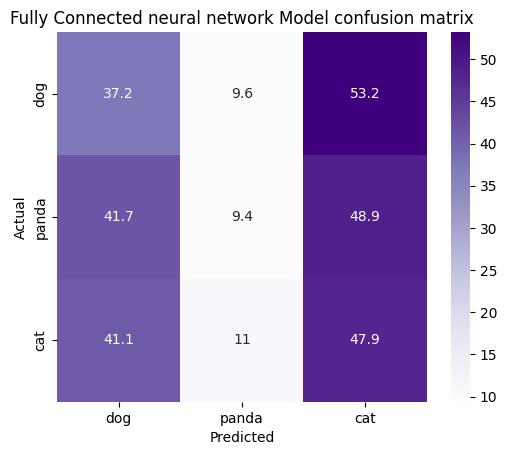

<Figure size 640x480 with 0 Axes>

Mean Accuracy: 0.3149999976158142
Mean f1 Score: 0.15964206162127254


In [16]:
#computing the scoring metrics from 10fold results into a confusion matrix 
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix 
import seaborn as sns 

mean_acc = sum(accuracyList)/len(accuracyList)
mean_f1 = sum(f1List)/len(f1List)
meanCM = sum(cmList)/len(cmList)

ax = plt.axes()
sns.heatmap(meanCM,ax=ax,annot=True,fmt='g',cmap='Purples',square=True)
fig = plt.figure()
fig.patch.set_facecolor('xkcd:grey')
ax.set_title('Fully Connected neural network Model confusion matrix')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()
print(f"Mean Accuracy: {mean_acc}")
print(f"Mean f1 Score: {mean_f1}")